# ContextAssembler vs CVEFixes Dataset Comparison

Analyzes how dataset construction methodology affects LLM vulnerability detection performance.
Compares **ContextAssembler** (function-level, CVE-context-enriched) against **CVEFixes** (file-level,
before/after-fix pairs) across 4 models — 8 benchmarks total.

Key questions:
- Does dataset granularity (function vs. file) affect model accuracy?
- Which methodology produces higher false negative rates (missed vulnerabilities)?
- How does token usage differ between the two dataset constructions?

In [20]:
import json
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
import seaborn as sns
from sklearn.metrics import matthews_corrcoef

In [21]:
## Configuration

PROJECT_ROOT = Path("__file__").resolve().parent.parent
RESULTS_FILE = PROJECT_ROOT / "results" / "context_assembler_experiments" / "vllm_comparison" / "experiment_plan_results.json"

MODEL_DISPLAY = {
    "qwen3-4b-thinking":               "Qwen3-4B (thinking)",
    "qwen3-8b-thinking":               "Qwen3-8B (thinking)",
    "llama3.2-3B":                     "Llama 3.2 (3B)",
    "deepseek-r1-distill-qwen2.5-7b":  "DeepSeek-R1 (7B)",
}

DATASET_DISPLAY = {
    "context_assembler": "ContextAssembler",
    "cvefixes":          "CVEFixes",
}

DATASET_COLORS = {
    "context_assembler": "#4e79a7",
    "cvefixes":          "#f28e2b",
}

MODEL_COLORS = {
    "qwen3-4b-thinking":               "#59a14f",
    "qwen3-8b-thinking":               "#76b7b2",
    "llama3.2-3B":                     "#e15759",
    "deepseek-r1-distill-qwen2.5-7b":  "#b07aa1",
}

sns.set_theme(style="whitegrid", palette="muted")
matplotlib.rcParams["figure.dpi"] = 120

In [22]:
## Data loading + flattening

def _dataset_key(path: str) -> str:
    """Classify dataset from its path string."""
    if "cvefixes" in path:
        return "cvefixes"
    return "context_assembler"


with open(RESULTS_FILE) as f:
    raw = json.load(f)

rows = []
for exp in raw["experiments"]:
    if not exp["is_success"]:
        continue
    bi = exp["benchmark_info"]
    m  = exp["metrics"]
    cm = m["details"]["confusion_matrix"]
    ts = bi["tokens_used_stats"]
    ps = bi["processing_time_stats"]
    rows.append({
        "model":            bi["model_name"],
        "dataset":          _dataset_key(bi["dataset_path"]),
        "accuracy":         m["summary"]["accuracy"],
        "precision":        m["summary"]["precision"],
        "recall":           m["summary"]["recall"],
        "f1":               m["summary"]["f1_score"],
        "specificity":      m["summary"]["specificity"],
        "TP":               cm["true_positives"],
        "TN":               cm["true_negatives"],
        "FP":               cm["false_positives"],
        "FN":               cm["false_negatives"],
        "tokens_avg":       ts["mean"],
        "tokens_std":       ts["std"],
        "time_avg":         ps["mean"],
        "total_samples":    bi["total_samples"],
        "thinking_enabled": bi["is_thinking_enabled"],
    })

df = pd.DataFrame(rows)
df["model_label"]   = df["model"].map(MODEL_DISPLAY)
df["dataset_label"] = df["dataset"].map(DATASET_DISPLAY)
print(f"Loaded {len(df)} experiments")
df[["model_label", "dataset_label", "accuracy", "recall", "specificity", "total_samples"]]

Loaded 8 experiments


,model_label,dataset_label,accuracy,recall,specificity,total_samples
0,Qwen3-4B (thinking),ContextAssembler,0.542714,0.788889,0.339450,199
1,Qwen3-4B (thinking),CVEFixes,0.546392,0.583333,0.524590,97
2,Qwen3-8B (thinking),ContextAssembler,0.497487,0.766667,0.275229,199
3,Qwen3-8B (thinking),CVEFixes,0.484536,0.777778,0.311475,97
4,Llama 3.2 (3B),ContextAssembler,0.470000,0.888889,0.127273,200
5,Llama 3.2 (3B),CVEFixes,0.368000,0.750000,0.095890,125
6,DeepSeek-R1 (7B),ContextAssembler,0.477387,0.088889,0.798165,199
7,DeepSeek-R1 (7B),CVEFixes,0.515464,0.111111,0.754098,97


In [23]:
## Derived metrics

df["FNR"]              = 1 - df["recall"]          # False Negative Rate
df["FPR"]              = 1 - df["specificity"]      # False Positive Rate
df["balanced_accuracy"]= (df["recall"] + df["specificity"]) / 2
df["youden_j"]         = df["recall"] + df["specificity"] - 1
df["miss_rate"]        = df["FN"] / (df["TP"] + df["FN"])  # alias for FNR

def _mcc(row):
    tp, tn, fp, fn = row["TP"], row["TN"], row["FP"], row["FN"]
    denom = math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return (tp * tn - fp * fn) / denom if denom > 0 else 0.0

df["MCC"] = df.apply(_mcc, axis=1)

df[["model_label", "dataset_label", "FNR", "FPR", "balanced_accuracy", "MCC", "youden_j"]].round(3)

,model_label,dataset_label,FNR,FPR,balanced_accuracy,MCC,youden_j
0,Qwen3-4B (thinking),ContextAssembler,0.211,0.661,0.564,0.142,0.128
1,Qwen3-4B (thinking),CVEFixes,0.417,0.475,0.554,0.104,0.108
2,Qwen3-8B (thinking),ContextAssembler,0.233,0.725,0.521,0.048,0.042
3,Qwen3-8B (thinking),CVEFixes,0.222,0.689,0.545,0.096,0.089
4,Llama 3.2 (3B),ContextAssembler,0.111,0.873,0.508,0.025,0.016
5,Llama 3.2 (3B),CVEFixes,0.250,0.904,0.423,-0.207,-0.154
6,DeepSeek-R1 (7B),ContextAssembler,0.911,0.202,0.444,-0.157,-0.113
7,DeepSeek-R1 (7B),CVEFixes,0.889,0.246,0.433,-0.164,-0.135


## Core Metrics Comparison

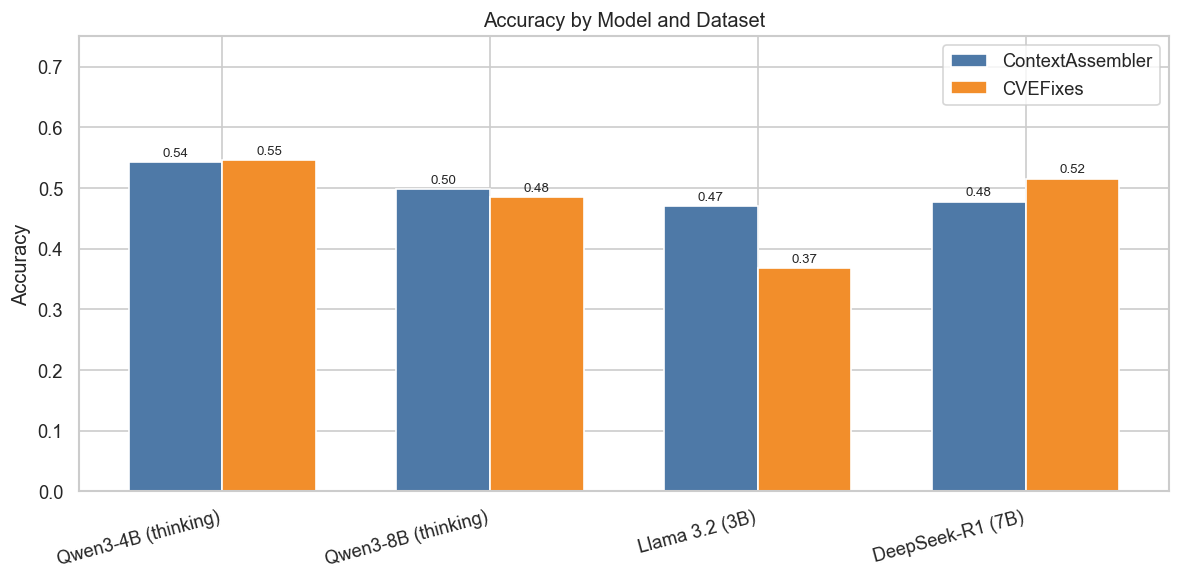

In [24]:
## Grouped bar chart: Accuracy by model × dataset

models   = df["model"].unique()
datasets = ["context_assembler", "cvefixes"]
x        = np.arange(len(models))
width    = 0.35

fig, ax = plt.subplots(figsize=(10, 5))

for i, ds in enumerate(datasets):
    vals   = [df.loc[(df["model"] == m) & (df["dataset"] == ds), "accuracy"].values[0] for m in models]
    offset = (i - 0.5) * width
    bars   = ax.bar(x + offset, vals, width, label=DATASET_DISPLAY[ds], color=DATASET_COLORS[ds])
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h + 0.005, f"{h:.2f}",
                ha="center", va="bottom", fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels([MODEL_DISPLAY[m] for m in models], rotation=15, ha="right")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy by Model and Dataset")
ax.set_ylim(0, 0.75)
ax.legend()
fig.tight_layout()
plt.show()

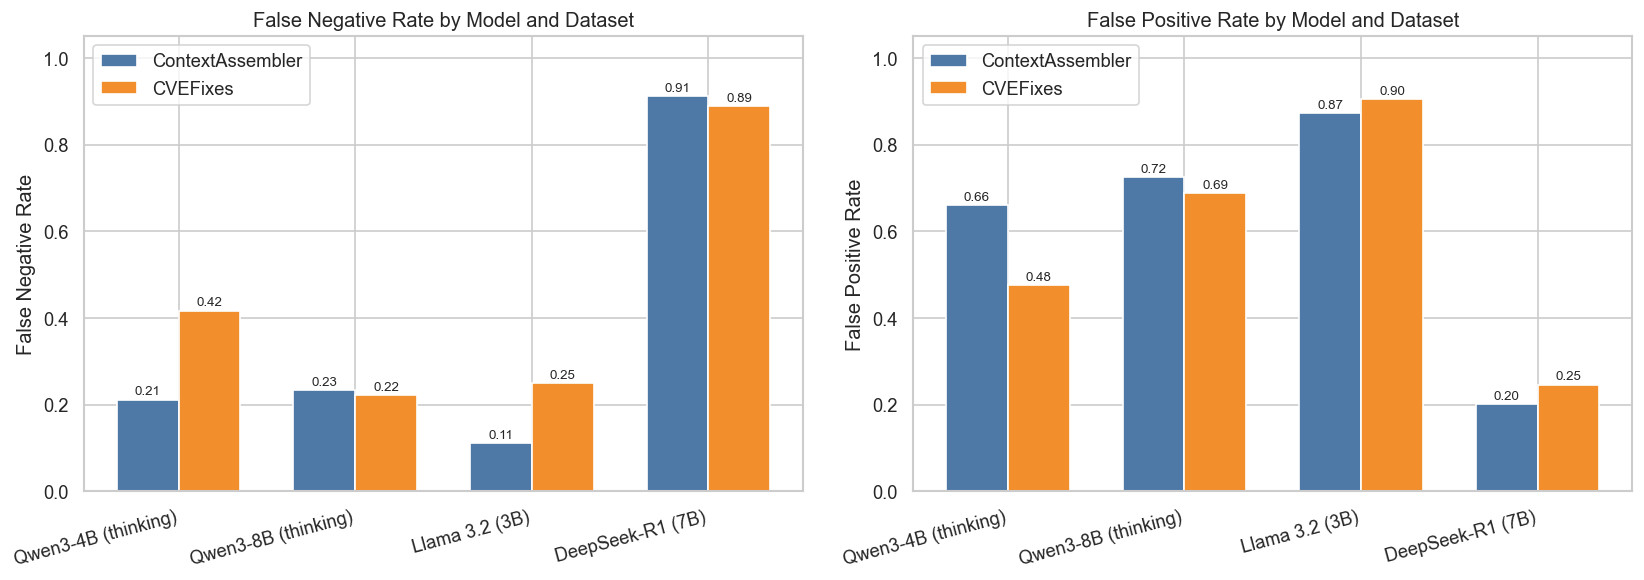

In [25]:
## Grouped bar chart: FNR and FPR by model × dataset (critical security metrics)

metrics_security = {"FNR": "False Negative Rate", "FPR": "False Positive Rate"}

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

for ax, (metric, metric_label) in zip(axes, metrics_security.items()):
    for i, ds in enumerate(datasets):
        vals   = [df.loc[(df["model"] == m) & (df["dataset"] == ds), metric].values[0] for m in models]
        offset = (i - 0.5) * width
        bars   = ax.bar(x + offset, vals, width, label=DATASET_DISPLAY[ds], color=DATASET_COLORS[ds])
        for bar in bars:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, h + 0.005, f"{h:.2f}",
                    ha="center", va="bottom", fontsize=8)
    ax.set_xticks(x)
    ax.set_xticklabels([MODEL_DISPLAY[m] for m in models], rotation=15, ha="right")
    ax.set_ylabel(metric_label)
    ax.set_title(f"{metric_label} by Model and Dataset")
    ax.set_ylim(0, 1.05)
    ax.legend()

fig.tight_layout()
plt.show()

/var/folders/cy/xkclg4xd0gjglf9yxn33fv6r0000gn/T/ipykernel_84019/776458585.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


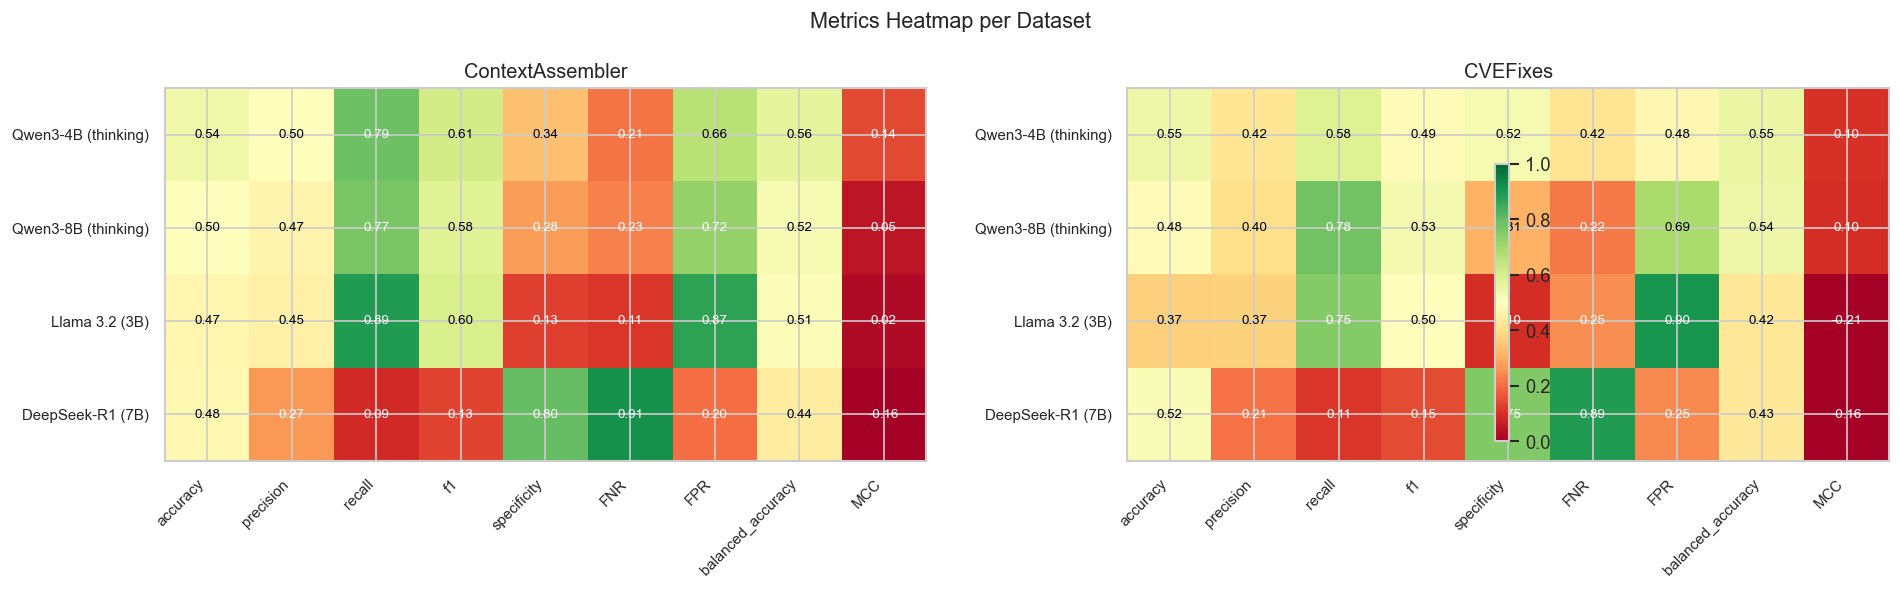

In [26]:
## Metrics heatmap — one per dataset side-by-side

heatmap_metrics = ["accuracy", "precision", "recall", "f1", "specificity", "FNR", "FPR", "balanced_accuracy", "MCC"]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for ax, ds in zip(axes, datasets):
    sub = df[df["dataset"] == ds].set_index("model_label")[heatmap_metrics]
    im  = ax.imshow(sub.values, cmap="RdYlGn", vmin=0, vmax=1, aspect="auto")
    ax.set_xticks(range(len(heatmap_metrics)))
    ax.set_xticklabels(heatmap_metrics, rotation=45, ha="right", fontsize=9)
    ax.set_yticks(range(len(sub)))
    ax.set_yticklabels(sub.index, fontsize=9)
    ax.set_title(DATASET_DISPLAY[ds])
    for i in range(len(sub)):
        for j in range(len(heatmap_metrics)):
            v = sub.values[i, j]
            ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=8,
                    color="black" if 0.3 < v < 0.7 else "white")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
fig.suptitle("Metrics Heatmap per Dataset", fontsize=13)
fig.tight_layout()
plt.show()

## Confusion Matrices

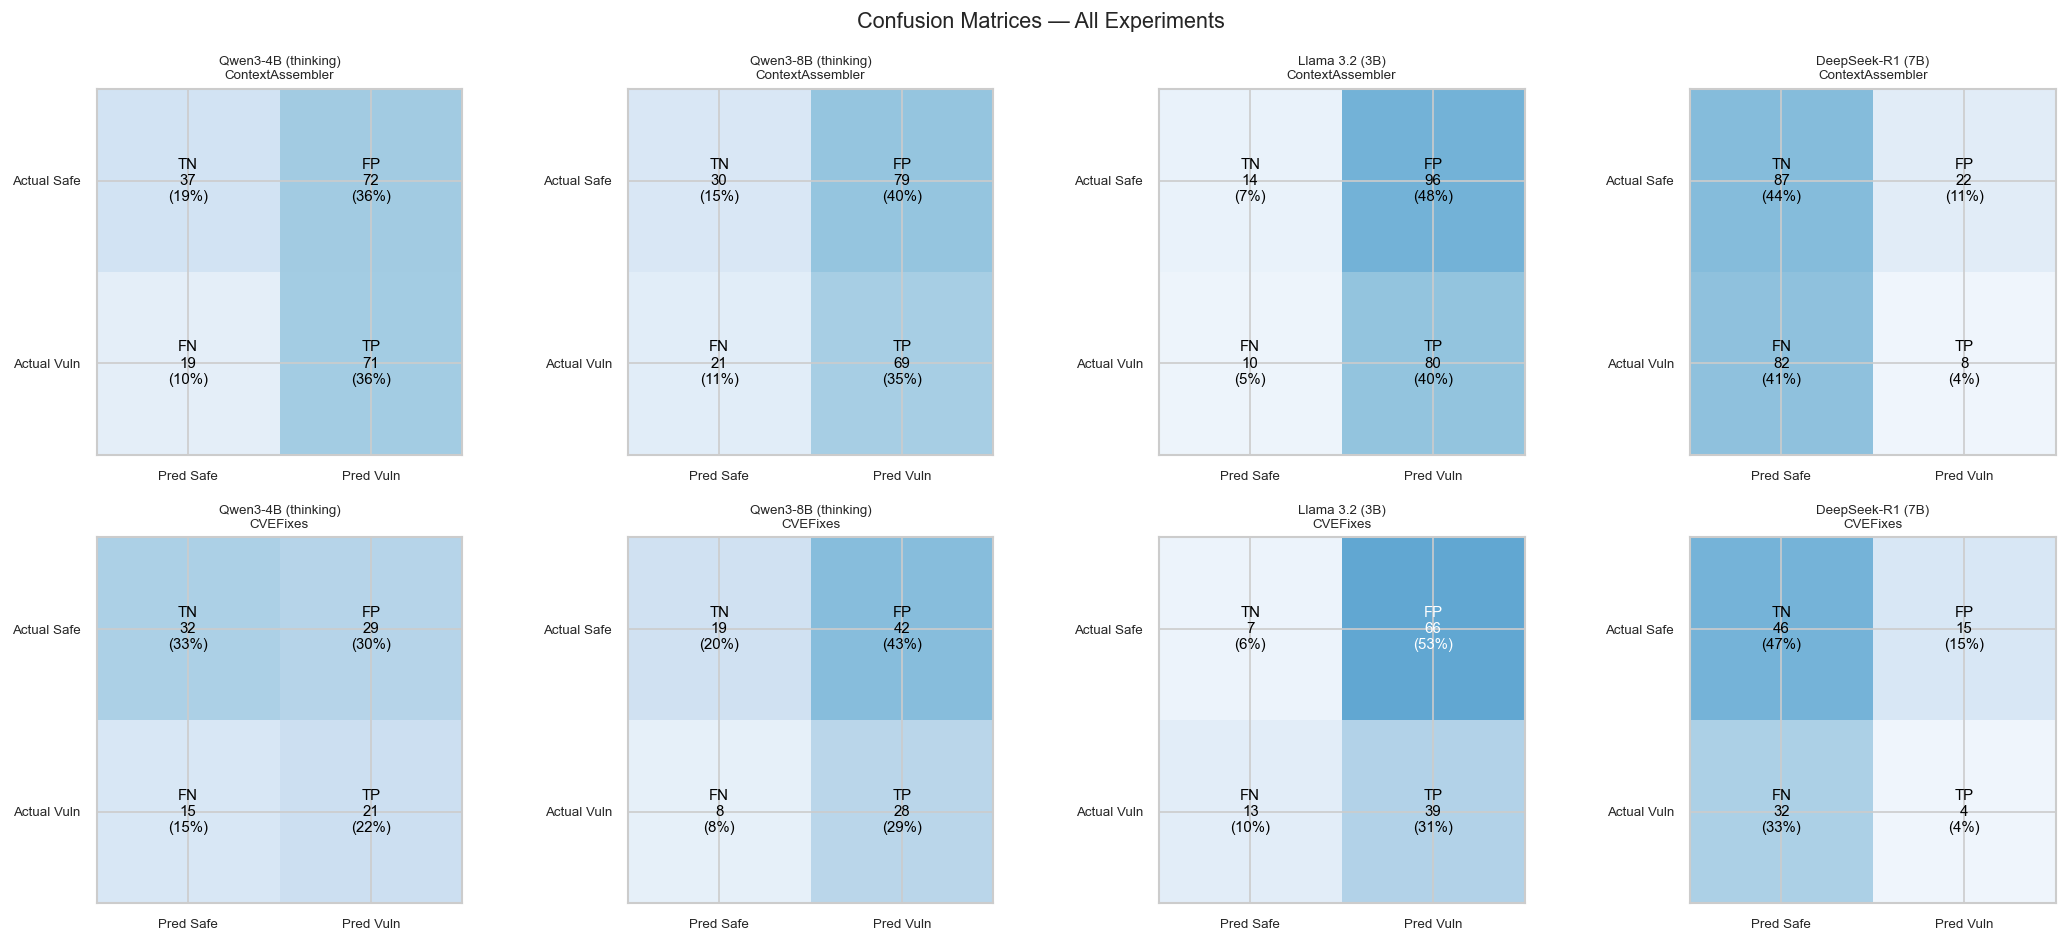

In [27]:
## 2×4 grid of confusion matrix heatmaps (one per experiment)

fig, axes = plt.subplots(2, 4, figsize=(18, 8))

for col, ds in enumerate(datasets):
    for row, m in enumerate(models):
        r   = df.loc[(df["model"] == m) & (df["dataset"] == ds)].iloc[0]
        ax  = axes[col][row]
        cm  = np.array([[r["TN"], r["FP"]], [r["FN"], r["TP"]]])
        n   = cm.sum()
        pct = cm / n

        im  = ax.imshow(pct, cmap="Blues", vmin=0, vmax=1)
        labels = [["TN", "FP"], ["FN", "TP"]]
        for i in range(2):
            for j in range(2):
                ax.text(j, i,
                        f"{labels[i][j]}\n{int(cm[i, j])}\n({pct[i, j]:.0%})",
                        ha="center", va="center", fontsize=9,
                        color="white" if pct[i, j] > 0.5 else "black")

        ax.set_xticks([0, 1])
        ax.set_xticklabels(["Pred Safe", "Pred Vuln"], fontsize=8)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(["Actual Safe", "Actual Vuln"], fontsize=8)
        ax.set_title(f"{MODEL_DISPLAY[m]}\n{DATASET_DISPLAY[ds]}", fontsize=8)

fig.suptitle("Confusion Matrices — All Experiments", fontsize=13)
fig.tight_layout()
plt.show()

## Dataset Methodology Comparison

In [28]:
## Paired delta table: CVEFixes − ContextAssembler for each model

delta_metrics = ["accuracy", "precision", "recall", "f1", "specificity", "FNR", "FPR", "balanced_accuracy", "MCC"]

pivot = df.pivot_table(index="model", columns="dataset", values=delta_metrics)
deltas = {}
for metric in delta_metrics:
    deltas[metric] = pivot[metric]["cvefixes"] - pivot[metric]["context_assembler"]

delta_df = pd.DataFrame(deltas)
delta_df.index = [MODEL_DISPLAY[m] for m in delta_df.index]
delta_df.index.name = "Model"
delta_df.columns.name = "Δ (CVEFixes − ContextAssembler)"

delta_df.round(3).style \
    .background_gradient(cmap="RdYlGn", axis=None, vmin=-0.4, vmax=0.4) \
    .format("{:+.3f}")

Δ (CVEFixes − ContextAssembler),accuracy,precision,recall,f1,specificity,FNR,FPR,balanced_accuracy,MCC
Model,,,,,,,,,
DeepSeek-R1 (7B),+0.038,-0.056,+0.022,+0.012,-0.044,-0.022,+0.044,-0.011,-0.007
Llama 3.2 (3B),-0.102,-0.083,-0.139,-0.105,-0.031,+0.139,+0.031,-0.085,-0.232
Qwen3-4B (thinking),+0.004,-0.077,-0.206,-0.121,+0.185,+0.206,-0.185,-0.010,-0.038
Qwen3-8B (thinking),-0.013,-0.066,+0.011,-0.052,+0.036,-0.011,-0.036,+0.024,+0.048


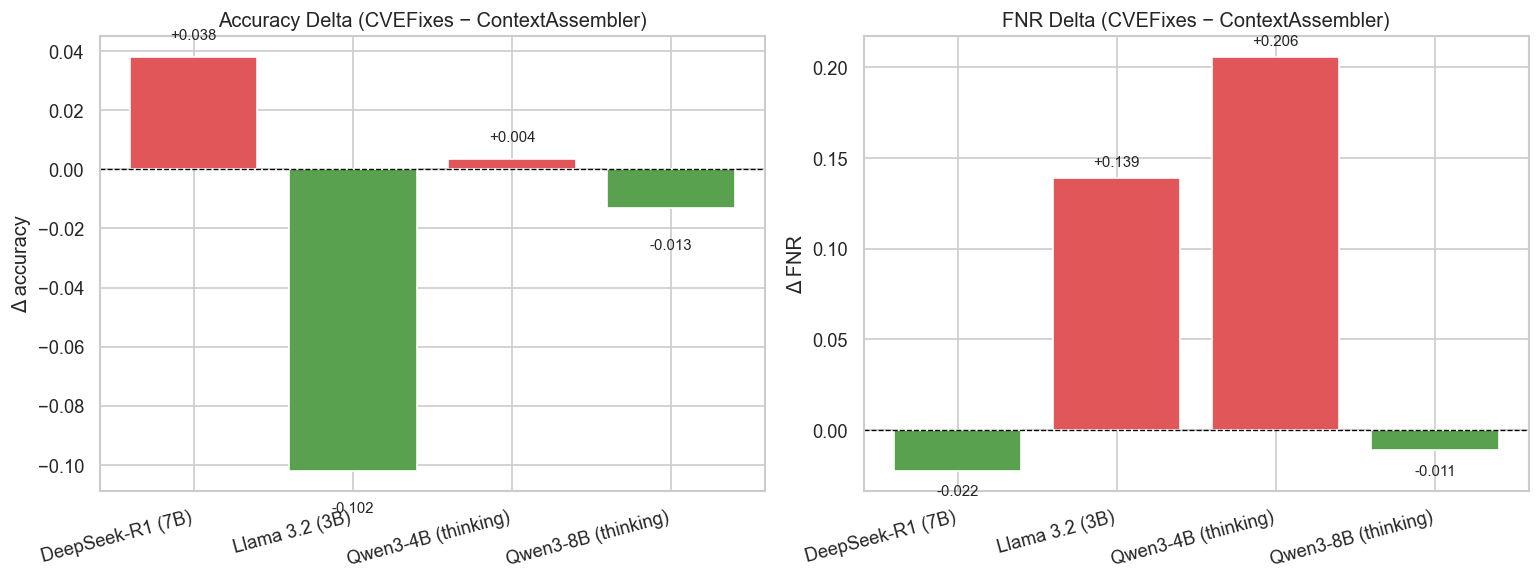

In [29]:
## Bar chart: accuracy delta and FNR delta between datasets per model

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

model_labels = list(delta_df.index)
x_idx = np.arange(len(model_labels))

for ax, metric, title in [
    (axes[0], "accuracy", "Accuracy Delta (CVEFixes − ContextAssembler)"),
    (axes[1], "FNR",      "FNR Delta (CVEFixes − ContextAssembler)"),
]:
    vals   = delta_df[metric].values
    colors = ["#e15759" if v > 0 else "#59a14f" for v in vals]
    bars   = ax.bar(x_idx, vals, color=colors)
    ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
    ax.set_xticks(x_idx)
    ax.set_xticklabels(model_labels, rotation=15, ha="right")
    ax.set_ylabel(f"Δ {metric}")
    ax.set_title(title)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2,
                h + (0.005 if h >= 0 else -0.015),
                f"{h:+.3f}", ha="center", va="bottom", fontsize=9)

fig.tight_layout()
plt.show()

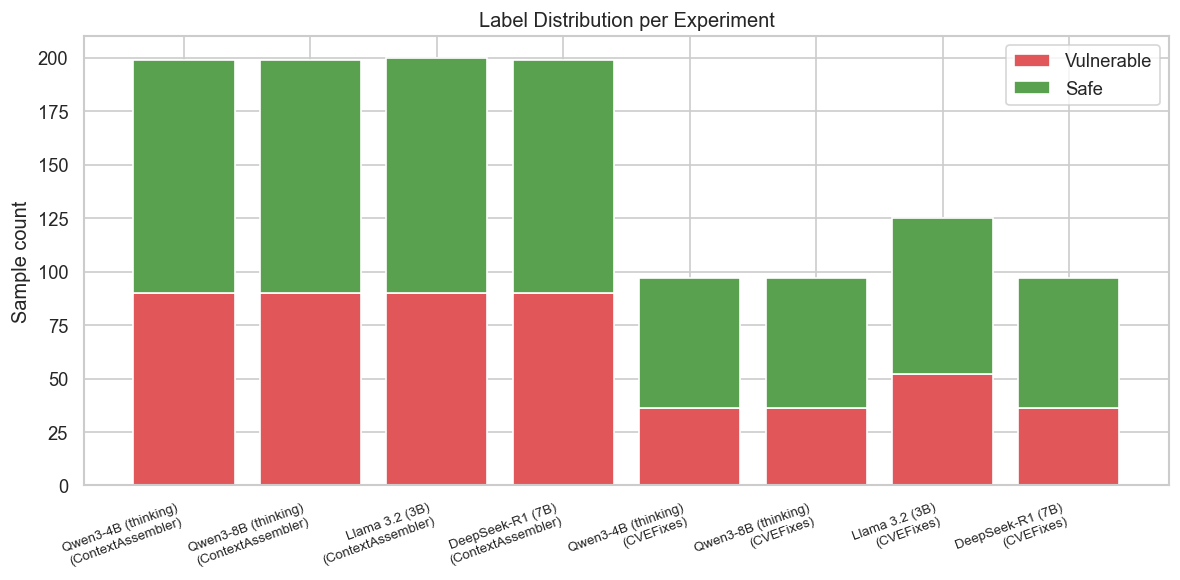

In [30]:
## Class imbalance analysis: label distribution per dataset

fig, ax = plt.subplots(figsize=(10, 5))

imbalance_rows = []
for ds in datasets:
    sub = df[df["dataset"] == ds]
    # aggregate across models for the same dataset (sum TP+FN = positives, TN+FP = negatives)
    for _, row in sub.iterrows():
        positives = row["TP"] + row["FN"]
        negatives = row["TN"] + row["FP"]
        imbalance_rows.append({"dataset": ds, "model": row["model"],
                                "Vulnerable": positives, "Safe": negatives})

imb_df = pd.DataFrame(imbalance_rows)
imb_df["label"] = imb_df.apply(lambda r: f"{MODEL_DISPLAY[r['model']]}\n({DATASET_DISPLAY[r['dataset']]})", axis=1)

x_idx2 = np.arange(len(imb_df))
bar_v  = ax.bar(x_idx2, imb_df["Vulnerable"], label="Vulnerable", color="#e15759")
bar_s  = ax.bar(x_idx2, imb_df["Safe"], bottom=imb_df["Vulnerable"], label="Safe", color="#59a14f")

ax.set_xticks(x_idx2)
ax.set_xticklabels(imb_df["label"], rotation=20, ha="right", fontsize=8)
ax.set_ylabel("Sample count")
ax.set_title("Label Distribution per Experiment")
ax.legend()
fig.tight_layout()
plt.show()

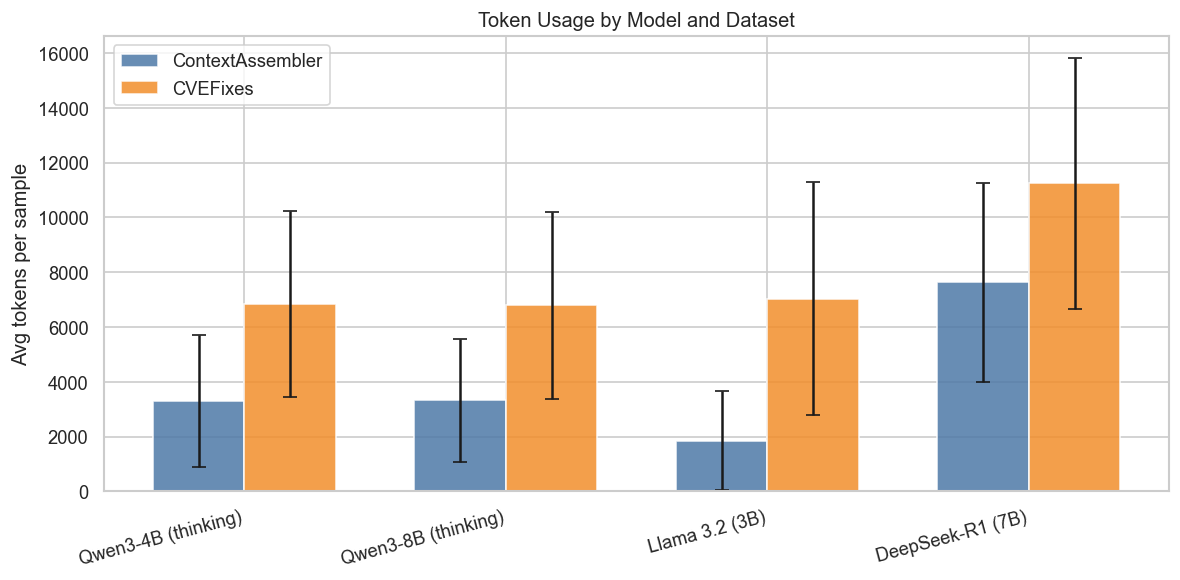

In [31]:
## Token usage: avg tokens per sample by model × dataset (with std error bars)

fig, ax = plt.subplots(figsize=(10, 5))

for i, ds in enumerate(datasets):
    vals = [df.loc[(df["model"] == m) & (df["dataset"] == ds), "tokens_avg"].values[0] for m in models]
    errs = [df.loc[(df["model"] == m) & (df["dataset"] == ds), "tokens_std"].values[0] for m in models]
    offset = (i - 0.5) * width
    ax.bar(x + offset, vals, width, yerr=errs, capsize=4,
           label=DATASET_DISPLAY[ds], color=DATASET_COLORS[ds], alpha=0.85)

ax.set_xticks(x)
ax.set_xticklabels([MODEL_DISPLAY[m] for m in models], rotation=15, ha="right")
ax.set_ylabel("Avg tokens per sample")
ax.set_title("Token Usage by Model and Dataset")
ax.legend()
fig.tight_layout()
plt.show()

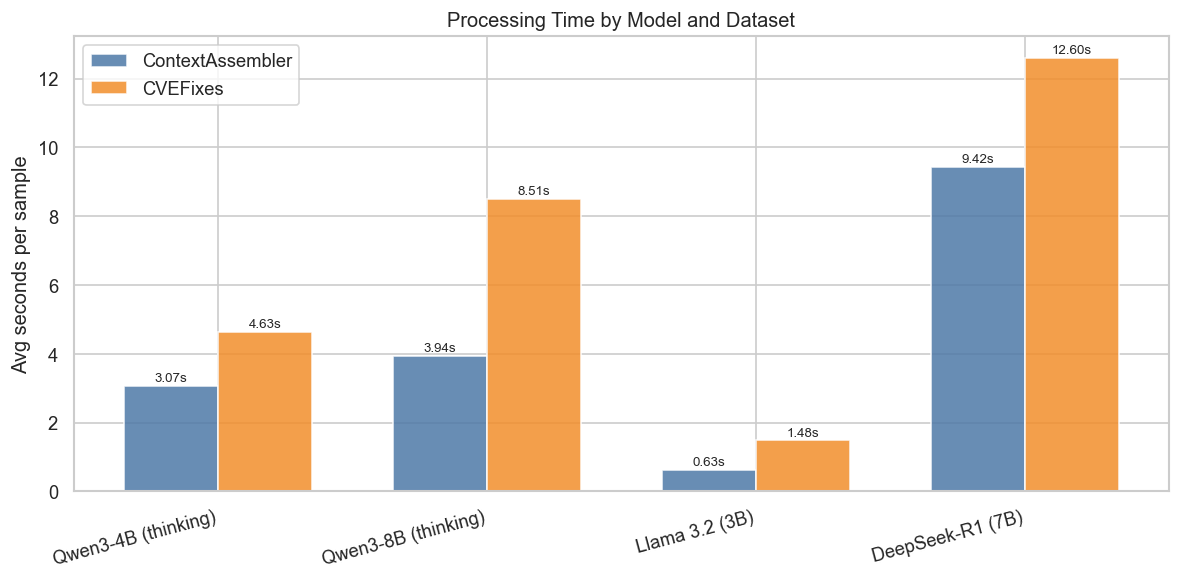

In [32]:
## Processing time: avg seconds per sample by model × dataset

fig, ax = plt.subplots(figsize=(10, 5))

for i, ds in enumerate(datasets):
    vals   = [df.loc[(df["model"] == m) & (df["dataset"] == ds), "time_avg"].values[0] for m in models]
    offset = (i - 0.5) * width
    bars   = ax.bar(x + offset, vals, width,
                    label=DATASET_DISPLAY[ds], color=DATASET_COLORS[ds], alpha=0.85)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h + 0.05, f"{h:.2f}s",
                ha="center", va="bottom", fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels([MODEL_DISPLAY[m] for m in models], rotation=15, ha="right")
ax.set_ylabel("Avg seconds per sample")
ax.set_title("Processing Time by Model and Dataset")
ax.legend()
fig.tight_layout()
plt.show()

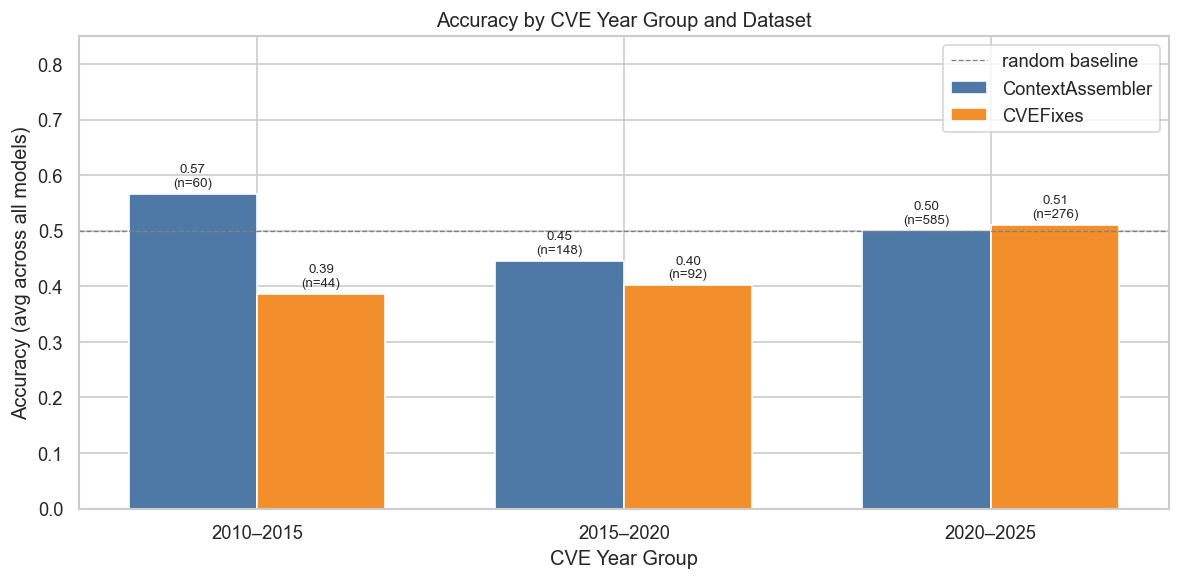

In [37]:
## Accuracy by CVE year group
# Loads per-sample predictions, maps each sample to its CVE year,
# bins into three periods, and plots a grouped bar chart (one bar per dataset per period).

import glob
import re

DATASET_DIR = PROJECT_ROOT / "datasets_processed" / "context_assembler"
RESULTS_DIR = PROJECT_ROOT / "results" / "context_assembler_experiments" / "vllm_comparison"

RESULTS_SUBDIR = {
    "context_assembler": "context_assembler_binary",
    "cvefixes":          "cvefixes_python_matched",
}

YEAR_BINS   = [2010, 2015, 2020, 2025]
YEAR_LABELS = ["2010–2015", "2015–2020", "2020–2025"]

def _cve_year(cve_id: str) -> int | None:
    m = re.search(r"CVE-(\d{4})-", cve_id or "", re.IGNORECASE)
    return int(m.group(1)) if m else None

def _year_group(year: int) -> str | None:
    for i in range(len(YEAR_BINS) - 1):
        if YEAR_BINS[i] <= year < YEAR_BINS[i + 1]:
            return YEAR_LABELS[i]
    return None

# Build sample_id → CVE year
sample_to_year: dict[str, int | None] = {}
for ds_key, ds_file in {
    "context_assembler": DATASET_DIR / "context_assembler_binary.json",
    "cvefixes":          DATASET_DIR / "cvefixes_python_matched.json",
}.items():
    with open(ds_file) as f:
        ds_data = json.load(f)
    for s in ds_data["samples"]:
        cve_id = s.get("metadata", {}).get("cve_id", "")
        sample_to_year[s["id"]] = _cve_year(cve_id)

# Load per-sample predictions and attach year group
pred_rows = []
for ds_key, ds_subdir in RESULTS_SUBDIR.items():
    for model in models:
        pattern = str(RESULTS_DIR / ds_subdir / model / "step_by_step" / "predictions_*.json")
        files   = sorted(glob.glob(pattern))
        if not files:
            print(f"[warn] No predictions found: {pattern}")
            continue
        with open(files[-1]) as f:
            preds = json.load(f)
        for p in preds:
            year = sample_to_year.get(p["sample_id"])
            if year is None:
                continue
            group = _year_group(year)
            if group is None:
                continue
            pred_rows.append({
                "dataset":    ds_key,
                "year_group": group,
                "correct":    int(p["predicted_label"] == p["true_label"]),
            })

pred_df = pd.DataFrame(pred_rows)

# Aggregate: mean accuracy and total sample count per (dataset, year_group)
group_acc = (
    pred_df
    .groupby(["dataset", "year_group"])
    .agg(accuracy=("correct", "mean"), n=("correct", "count"))
    .reset_index()
)

# Grouped bar chart: x = year group, two bars per group (one per dataset)
x_idx  = np.arange(len(YEAR_LABELS))
width  = 0.35

fig, ax = plt.subplots(figsize=(10, 5))

for i, ds in enumerate(datasets):
    sub    = group_acc[group_acc["dataset"] == ds].set_index("year_group")
    vals   = [sub.loc[lbl, "accuracy"] if lbl in sub.index else 0.0 for lbl in YEAR_LABELS]
    counts = [int(sub.loc[lbl, "n"])   if lbl in sub.index else 0   for lbl in YEAR_LABELS]
    offset = (i - 0.5) * width
    bars   = ax.bar(x_idx + offset, vals, width,
                    label=DATASET_DISPLAY[ds], color=DATASET_COLORS[ds])
    for bar, acc, n in zip(bars, vals, counts):
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h + 0.008,
                f"{acc:.2f}\n(n={n})", ha="center", va="bottom", fontsize=8)

ax.axhline(0.5, color="grey", linewidth=0.8, linestyle="--", label="random baseline")
ax.set_xticks(x_idx)
ax.set_xticklabels(YEAR_LABELS)
ax.set_xlabel("CVE Year Group")
ax.set_ylabel("Accuracy (avg across all models)")
ax.set_title("Accuracy by CVE Year Group and Dataset")
ax.set_ylim(0, 0.85)
ax.legend()
fig.tight_layout()
plt.show()


## Advanced Metrics

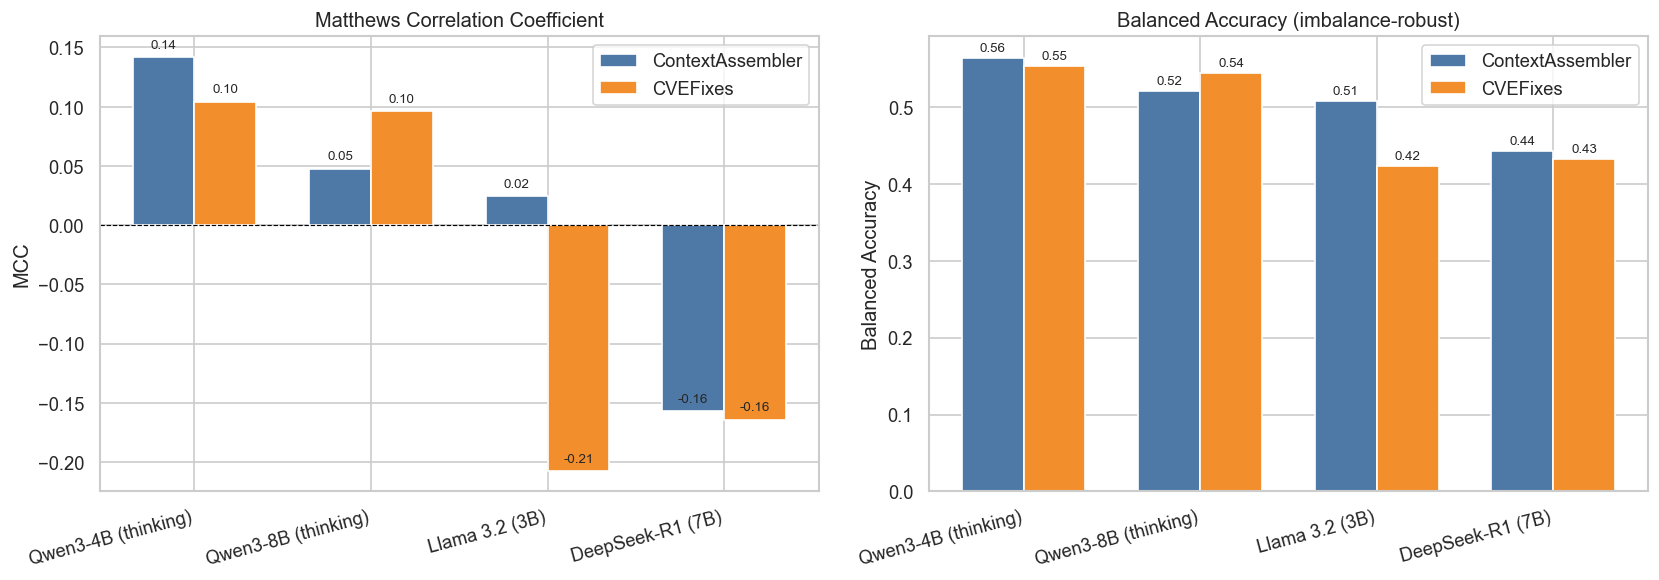

In [34]:
## MCC and Balanced Accuracy comparison

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, metric, ylabel, title in [
    (axes[0], "MCC",              "MCC",               "Matthews Correlation Coefficient"),
    (axes[1], "balanced_accuracy","Balanced Accuracy",  "Balanced Accuracy (imbalance-robust)"),
]:
    for i, ds in enumerate(datasets):
        vals   = [df.loc[(df["model"] == m) & (df["dataset"] == ds), metric].values[0] for m in models]
        offset = (i - 0.5) * width
        bars   = ax.bar(x + offset, vals, width, label=DATASET_DISPLAY[ds], color=DATASET_COLORS[ds])
        for bar in bars:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, h + 0.005, f"{h:.2f}",
                    ha="center", va="bottom", fontsize=8)
    ax.axhline(0, color="black", linewidth=0.7, linestyle="--")
    ax.set_xticks(x)
    ax.set_xticklabels([MODEL_DISPLAY[m] for m in models], rotation=15, ha="right")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()

fig.tight_layout()
plt.show()

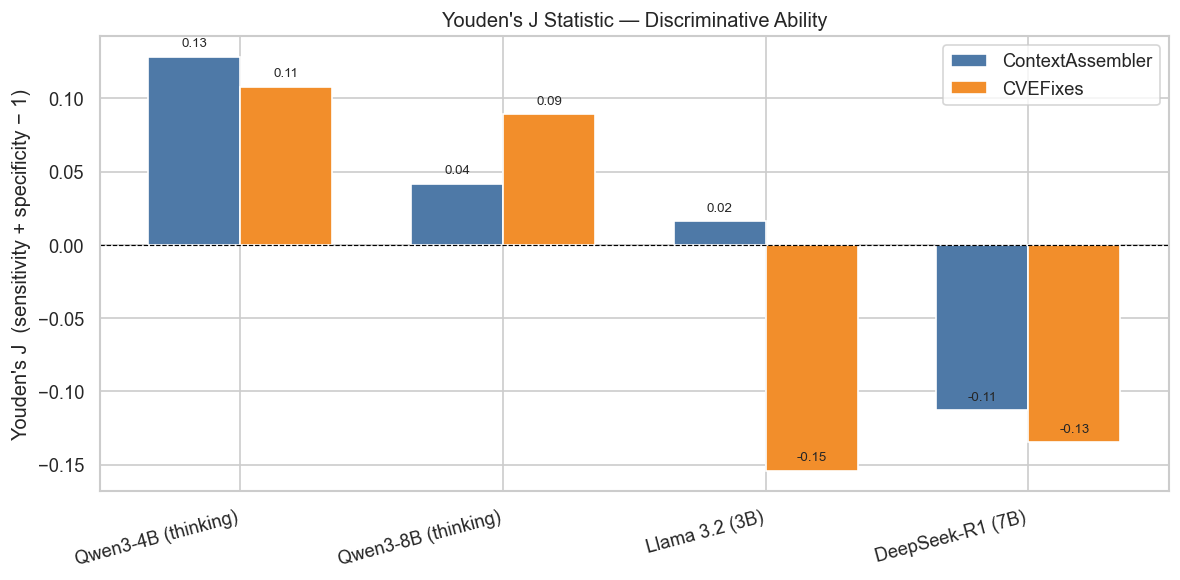

In [35]:
## Youden's J statistic — overall discriminative ability

fig, ax = plt.subplots(figsize=(10, 5))

for i, ds in enumerate(datasets):
    vals   = [df.loc[(df["model"] == m) & (df["dataset"] == ds), "youden_j"].values[0] for m in models]
    offset = (i - 0.5) * width
    bars   = ax.bar(x + offset, vals, width, label=DATASET_DISPLAY[ds], color=DATASET_COLORS[ds])
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h + 0.005, f"{h:.2f}",
                ha="center", va="bottom", fontsize=8)

ax.axhline(0, color="black", linewidth=0.7, linestyle="--")
ax.set_xticks(x)
ax.set_xticklabels([MODEL_DISPLAY[m] for m in models], rotation=15, ha="right")
ax.set_ylabel("Youden's J  (sensitivity + specificity − 1)")
ax.set_title("Youden's J Statistic — Discriminative Ability")
ax.legend()
fig.tight_layout()
plt.show()

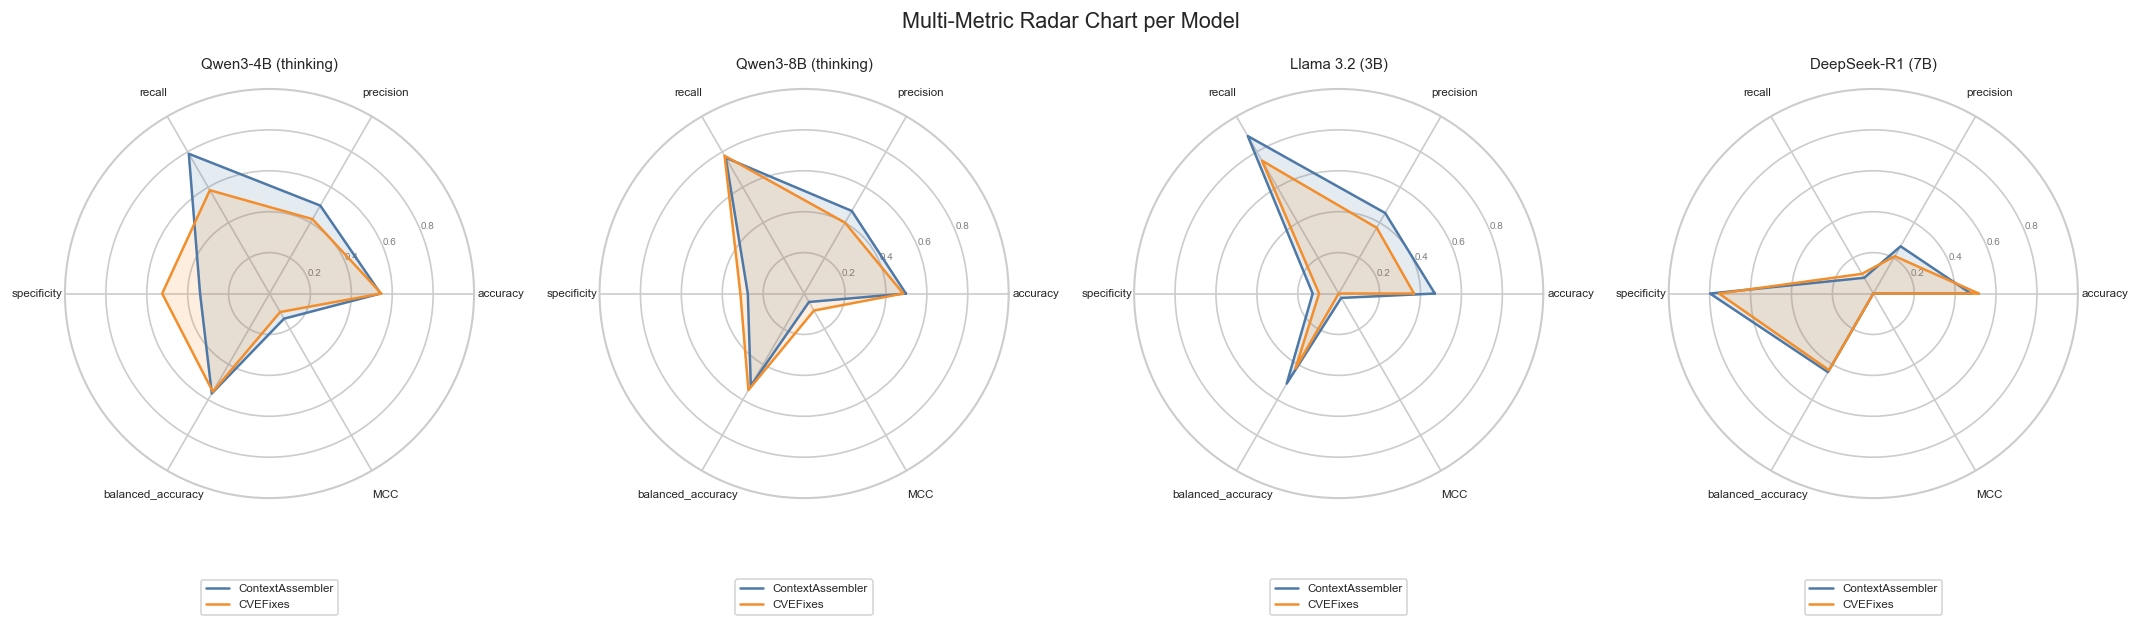

In [36]:
## Radar / spider chart — per-model multi-metric comparison across both datasets

radar_metrics = ["accuracy", "precision", "recall", "specificity", "balanced_accuracy", "MCC"]
N      = len(radar_metrics)
angles = [n / N * 2 * math.pi for n in range(N)]
angles += angles[:1]   # close the polygon

fig, axes = plt.subplots(1, len(models), figsize=(18, 5),
                         subplot_kw=dict(polar=True))

for ax, model in zip(axes, models):
    for ds in datasets:
        row    = df.loc[(df["model"] == model) & (df["dataset"] == ds)].iloc[0]
        values = [row[m] for m in radar_metrics]
        # Clamp MCC to [0, 1] for radar readability
        values = [max(0, v) for v in values]
        values += values[:1]
        ax.plot(angles, values, label=DATASET_DISPLAY[ds], color=DATASET_COLORS[ds], linewidth=1.5)
        ax.fill(angles, values, color=DATASET_COLORS[ds], alpha=0.15)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_metrics, fontsize=7)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], fontsize=6, color="grey")
    ax.set_title(MODEL_DISPLAY[model], fontsize=9, pad=12)
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), fontsize=7)

fig.suptitle("Multi-Metric Radar Chart per Model", fontsize=13)
fig.tight_layout()
plt.show()

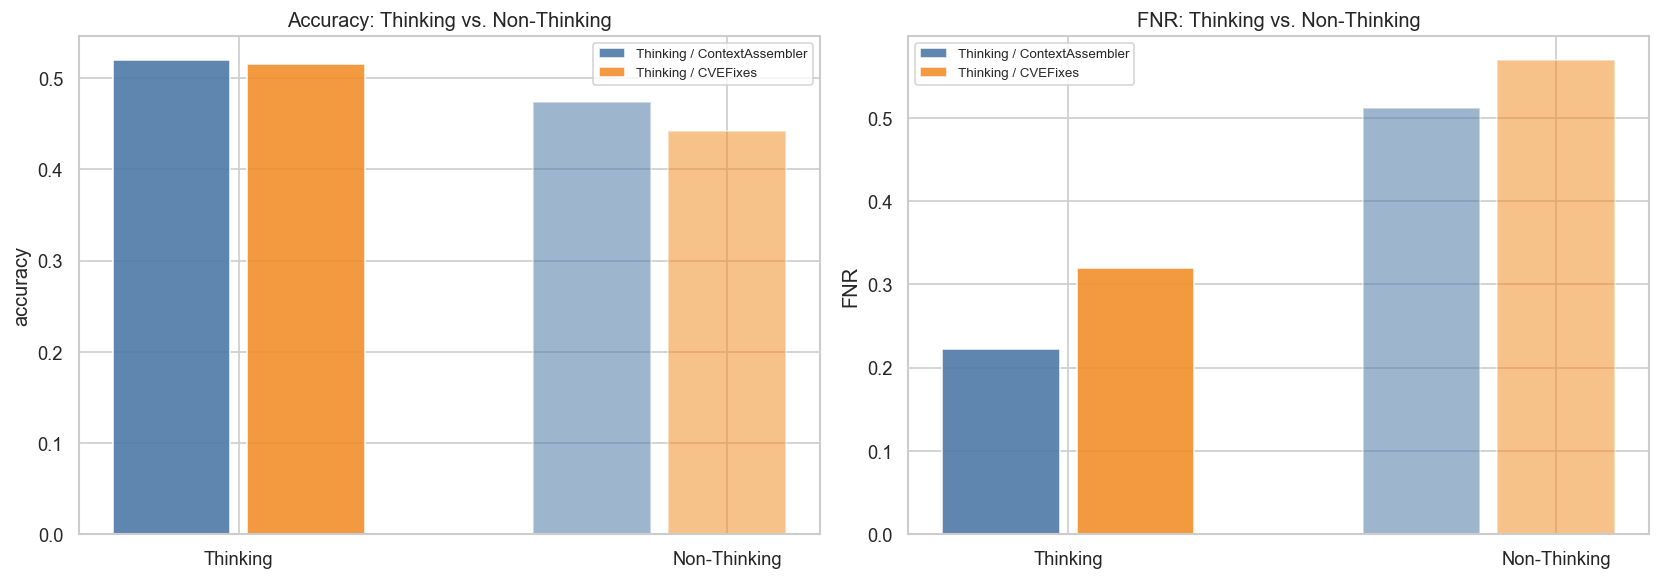

In [18]:
## Thinking vs. non-thinking model comparison

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, metric, title in [
    (axes[0], "accuracy", "Accuracy: Thinking vs. Non-Thinking"),
    (axes[1], "FNR",      "FNR: Thinking vs. Non-Thinking"),
]:
    for i, (thinking, group_label) in enumerate([(True, "Thinking"), (False, "Non-Thinking")]):
        sub = df[df["thinking_enabled"] == thinking]
        for j, ds in enumerate(datasets):
            sub_ds = sub[sub["dataset"] == ds]
            avg    = sub_ds[metric].mean()
            ax.bar(
                i * 2.5 + j * 0.8, avg, 0.7,
                color=DATASET_COLORS[ds],
                alpha=0.9 if thinking else 0.55,
                label=f"{group_label} / {DATASET_DISPLAY[ds]}" if i == 0 else None
            )

    ax.set_xticks([0.4, 3.3])
    ax.set_xticklabels(["Thinking", "Non-Thinking"])
    ax.set_ylabel(metric)
    ax.set_title(title)
    ax.legend(fontsize=8)

fig.tight_layout()
plt.show()

## Summary Table

In [19]:
## Styled summary DataFrame — all 8 experiments sorted by dataset then accuracy desc

summary_cols = [
    "model_label", "dataset_label", "total_samples",
    "accuracy", "precision", "recall", "f1", "specificity",
    "FNR", "FPR", "balanced_accuracy", "MCC", "youden_j",
    "TP", "TN", "FP", "FN",
    "tokens_avg", "time_avg", "thinking_enabled",
]

summary = (
    df[summary_cols]
    .sort_values(["dataset_label", "accuracy"], ascending=[True, False])
    .reset_index(drop=True)
)

float_cols = ["accuracy", "precision", "recall", "f1", "specificity",
              "FNR", "FPR", "balanced_accuracy", "MCC", "youden_j"]

summary.rename(columns={
    "model_label": "Model", "dataset_label": "Dataset", "total_samples": "N",
    "tokens_avg": "Tokens/sample", "time_avg": "Sec/sample",
    "thinking_enabled": "Thinking",
}, inplace=True)

grad_cols = [c for c in float_cols if c in summary.columns]

summary.style \
    .background_gradient(subset=grad_cols, cmap="RdYlGn", axis=0) \
    .format({c: "{:.3f}" for c in grad_cols}) \
    .format({"Tokens/sample": "{:,.0f}", "Sec/sample": "{:.3f}"})

,Model,Dataset,N,accuracy,precision,recall,f1,specificity,FNR,FPR,balanced_accuracy,MCC,youden_j,TP,TN,FP,FN,Tokens/sample,Sec/sample,Thinking
0,Qwen3-4B (thinking),CVEFixes,97,0.546392,0.420000,0.583333,0.488372,0.524590,0.416667,0.475410,0.553962,0.104327,0.107923,21,32,29,15,"6,837",4.630,True
1,DeepSeek-R1 (7B),CVEFixes,97,0.515464,0.210526,0.111111,0.145455,0.754098,0.888889,0.245902,0.432605,-0.164078,-0.134791,4,46,15,32,"11,238",12.605,False
2,Qwen3-8B (thinking),CVEFixes,97,0.484536,0.400000,0.777778,0.528302,0.311475,0.222222,0.688525,0.544627,0.096208,0.089253,28,19,42,8,"6,788",8.506,True
3,Llama 3.2 (3B),CVEFixes,125,0.368000,0.371429,0.750000,0.496815,0.095890,0.250000,0.904110,0.422945,-0.207197,-0.154110,39,7,66,13,"7,037",1.481,False
4,Qwen3-4B (thinking),ContextAssembler,199,0.542714,0.496503,0.788889,0.609442,0.339450,0.211111,0.660550,0.564169,0.142046,0.128338,71,37,72,19,"3,301",3.068,True
5,Qwen3-8B (thinking),ContextAssembler,199,0.497487,0.466216,0.766667,0.579832,0.275229,0.233333,0.724771,0.520948,0.047763,0.041896,69,30,79,21,"3,318",3.942,True
6,DeepSeek-R1 (7B),ContextAssembler,199,0.477387,0.266667,0.088889,0.133333,0.798165,0.911111,0.201835,0.443527,-0.157109,-0.112946,8,87,22,82,"7,627",9.424,False
7,Llama 3.2 (3B),ContextAssembler,200,0.470000,0.454545,0.888889,0.601504,0.127273,0.111111,0.872727,0.508081,0.024742,0.016162,80,14,96,10,"1,849",0.634,False
